# Dataset

We used the dataset  from Kaggle [Animal Species Classification - V3](https://www.kaggle.com/datasets/utkarshsaxenadn/animal-image-classification-dataset).
The authors created it to to have a data set for classifying animal species.
It is licensed under the "CC0: Public Domain" license.

The dataset comes already with a train, validation and test split for a total of 15 different animal classes.
The training data contains 2000 images per class with 256x256 pixels per picture.
The validation set contains 100/200 images per class
and the testing data is filled with a random number
of images per class.

Since the project requires to have atleast 500 images per class and that 30% should be locked for the test set, 
we will only use the data contained in the training set and split it ourselves.
In the following code segments we split the data to 0.3 test and 0.7 training data.
From the 0.8 training data we split it again to reserve data for validation.
We use a hardcoded seed to ensure the same shuffle.
The training was precleaned to only contain the data directories for the 10 classes used in this project.

In [2]:
# Import dependencies
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #Workaround for kernel crash because multiple copies of the OpenMP runtime have been linked

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras import models
from tensorflow.keras import layers
import json


In [9]:
#Set os env variable. Only required if not already set.
#This should point to the folder which contains the training data
os.environ["aiap_data_path"] = "D:/training/animals"

In [10]:
data_path = os.environ["aiap_data_path"]
batch_size = 32 # the whole data will be split into a total of the amount of batches
img_height = 64 # The image will be resized when imported to this height
img_width = 64 # The image will be resized when imported to this width
img_channels = 3 #RGB
shuffle_seed = 1234 # The seed for the data shuffle
shuffle_enabled = True
test_data_ratio = 0.3
validation_data_ratio= 0.2
img_classes = [ #explicitly defined to avoid errors
    "Cow",
    "Dog",
    "Elephant",
    "Gorilla",
    "Hippo",
    "Lizard",
    "Monkey",
    "Panda",
    "Tiger",
    "Zebra"
    ]


In [11]:
#Load the data and split it to training & test
data = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, #directory where data is located
    class_names=img_classes, #pass in names of classes
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=shuffle_enabled, #shuffle the data
    seed=shuffle_seed, #seed for the shuffling and transformations
    validation_split=test_data_ratio, #we reserve a ratio of the data for the test set
    subset="both", #return both test & training set
)
print("do not confuse the output here. we explicitly use the validation data as test data and split the training data again for the validation data")

Found 20000 files belonging to 10 classes.
Using 14000 files for training.
Using 6000 files for validation.
do not confuse the output here. we explicitly use the validation data as test data and split the training data again for the validation data


In [12]:
# print information about the data
print("data variable contains:",len(data),"elements")
training_data= data[0]
test_data = data[1]
assert isinstance(training_data, tf.data.Dataset)
assert isinstance(test_data, tf.data.Dataset)
print("training data size:",training_data.cardinality())
print("test data size:", test_data.cardinality())
print("class names:", training_data.class_names)


data variable contains: 2 elements
training data size: tf.Tensor(438, shape=(), dtype=int64)
test data size: tf.Tensor(188, shape=(), dtype=int64)
class names: ['Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Panda', 'Tiger', 'Zebra']


In [13]:
# finally split the current training data into a separate validation set
training_data_size = sum(1 for _ in training_data)
print(training_data_size, "batches")
validation_data_size = int(validation_data_ratio * training_data_size)
print(validation_data_size, "batches")
validation_data = training_data.take(validation_data_size)
class_names = training_data.class_names
training_data = training_data.skip(validation_data_size)

438 batches
87 batches


## Normalize Data

In [14]:
# Print the shape of the input data
print("Shape of training data:")
i = 0
for x, y in training_data:
    print(x.shape)
    print(y.shape)
    print("True label:", y[0])
    i=i+1
    if i>3:
        break

Shape of training data:
(32, 64, 64, 3)
(32,)
True label: tf.Tensor(6, shape=(), dtype=int32)
(32, 64, 64, 3)
(32,)
True label: tf.Tensor(6, shape=(), dtype=int32)
(32, 64, 64, 3)
(32,)
True label: tf.Tensor(4, shape=(), dtype=int32)
(32, 64, 64, 3)
(32,)
True label: tf.Tensor(2, shape=(), dtype=int32)


In [15]:
# print the pixel value range
def printPixelValueRange(dataset):
    for image, _ in dataset.take(1):
        print(f"Max value: {np.max(image[0])}")
printPixelValueRange(training_data)
printPixelValueRange(validation_data)
printPixelValueRange(test_data)

Max value: 255.0
Max value: 253.25
Max value: 254.25


In [16]:
# normalize data between 0 and 1
def normalize(image,label):
    image = tf.cast(image/255.0 ,tf.float32)
    return image,label

training_data = training_data.map(normalize)
validation_data = validation_data.map(normalize)
test_data = test_data.map(normalize)


printPixelValueRange(training_data)
printPixelValueRange(validation_data)
printPixelValueRange(test_data)

Max value: 0.9960784316062927
Max value: 0.9941176176071167
Max value: 0.9970588088035583


## Data Class Distribution
Plots data distribution over the different classes from the different datasets.

In [17]:
# Initialize counters for each class
class_counts_training = {class_name: 0 for class_name in class_names}
class_counts_validation = {class_name: 0 for class_name in class_names}
class_counts_test = {class_name: 0 for class_name in class_names}

# Iterate through the dataset to count occurrences of each class
for batch in training_data:
    labels = batch[1]  # Assuming labels are in the second element of each batch
    for label in labels:
        class_counts_training[class_names[label]] += 1

for batch in validation_data:
    labels = batch[1]  # Assuming labels are in the second element of each batch
    for label in labels:
        class_counts_validation[class_names[label]] += 1

for batch in test_data:
    labels = batch[1]  # Assuming labels are in the second element of each batch
    for label in labels:
        class_counts_test[class_names[label]] += 1

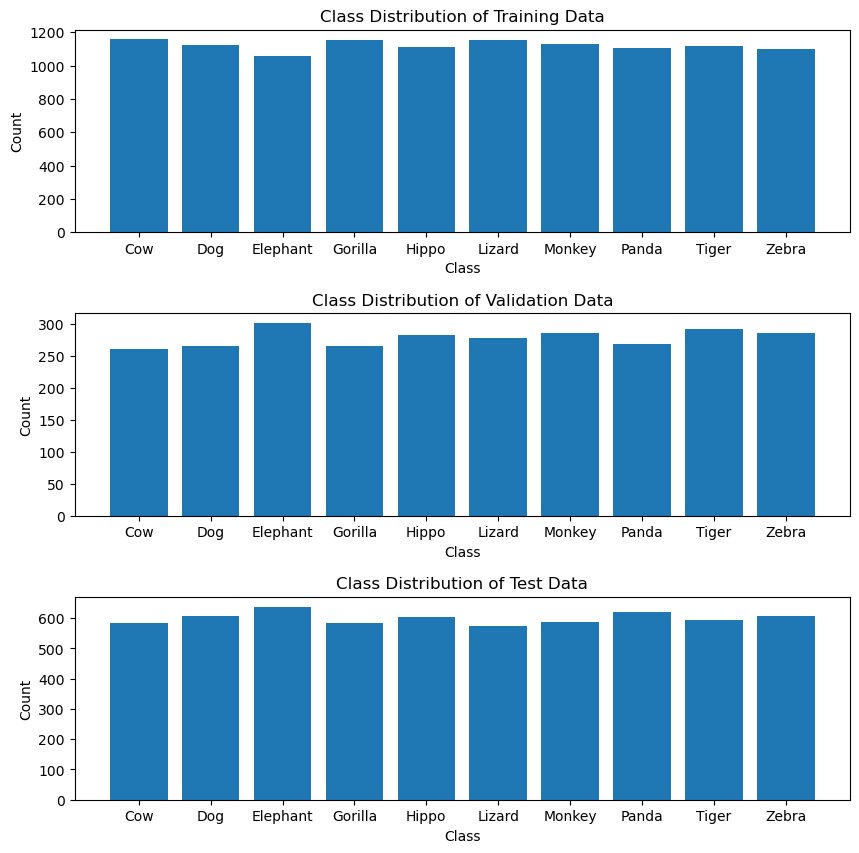

In [18]:

# Plot the class distribution
fig, (sub1, sub2, sub3) = plt.subplots(3, 1, figsize=(10, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

sub1.bar(class_counts_training.keys(), class_counts_training.values())
sub1.set_xlabel('Class')
sub1.set_ylabel('Count')
sub1.set_title('Class Distribution of Training Data')

sub2.bar(class_counts_validation.keys(), class_counts_validation.values())
sub2.set_xlabel('Class')
sub2.set_ylabel('Count')
sub2.set_title('Class Distribution of Validation Data')

sub3.bar(class_counts_test.keys(), class_counts_test.values())
sub3.set_xlabel('Class')
sub3.set_ylabel('Count')
sub3.set_title('Class Distribution of Test Data')
plt.show()

Data is more or less evenly distributed.

## Data Classes Plot

{'_input_dataset': <SkipDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, '_use_inter_op_parallelism': True, '_preserve_cardinality': True, '_map_func': <tensorflow.python.data.ops.structured_function.StructuredFunctionWrapper object at 0x00000218AE2A2A10>, '_name': None, '_variant_tensor_attr': <tf.Tensor: shape=(), dtype=variant, value=<MapDatasetOp::Dataset>>, '_graph_attr': <tensorflow.python.framework.ops.Graph object at 0x000002188DAD90F0>, '_options_attr': <tensorflow.python.data.ops.options.Options object at 0x00000218AE2D93C0>}


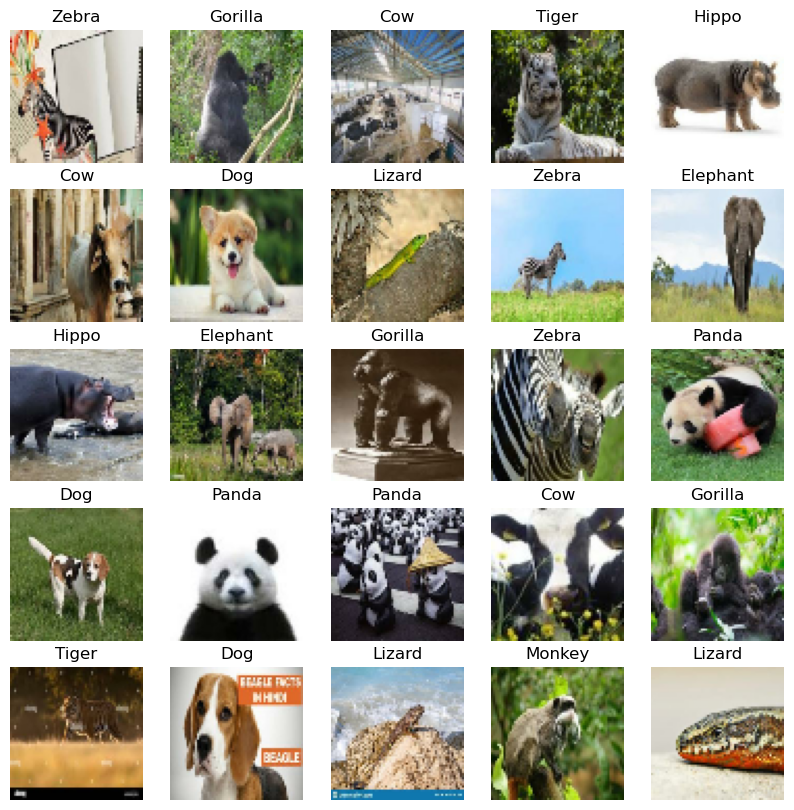

In [69]:
plt.figure(figsize=(10, 10))
print(vars(training_data))
for images, labels in training_data.take(1): # takes one batch
  for i in range(25):
    try:
      ax = plt.subplot(5, 5, i + 1)
      plt.imshow(images[i]) #.numpy().astype("uint8")
      plt.title(class_names[labels[i]])
      plt.axis("off")
    except Exception as e:
      print(f"Error at index {i}: {e}")

Data is low quality. Notice the computer generated images like in the upper left corner. Some pictures contain text or other objects.

## Exploratory data analysis
The data set consists of low value images. As you can see from the visualization above, a lot of them include text, are computer generated images or have other objects within the image space. The classes are well represented, each class has the same amount of images. After splitting the images into different sets they are still well distributed, as can be seen from the Class Distribution graph above. It also shall be noted that we did not use the augmented dataset. 

# First Architecture (Undefitting)
For the undefitting model we used a simple architecture with one conv and two deep layers.
The architecture has 2282 parameters.

In [72]:
simple_model = models.Sequential()
simple_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, img_channels)))
simple_model.add(layers.MaxPooling2D((32, 32)))
simple_model.add(layers.Flatten())
simple_model.add(layers.Dense(32, activation='relu'))
simple_model.add(layers.Dense(10))
simple_model.summary()

Model: "sequential_6"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 10)                330       
                                                                 
Total params: 2,282
Trainable params: 2,282
Non-trainable params: 0
_________________________________________________________________


In [73]:
simple_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [74]:
# history dictionary for successive combined trainings
combined_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [110]:
# save history data to disk
# Save the dictionary to disk using JSON
with open('combined_history_simple_model.json', 'w') as f:
    json.dump(combined_history, f)

In [73]:
# load history data from disk
import json

with open('combined_history_simple_model.json', 'r') as f:
    combined_history = json.load(f)

In [75]:
# train
history = simple_model.fit(training_data, epochs=100, 
                           validation_data=validation_data)
# Update the combined_history with the first training session
for key in combined_history.keys():
    combined_history[key].extend(history.history[key])

Epoch 1/100


351/351 [==============================] - 5s 12ms/step - loss: 2.1898 - accuracy: 0.2123 - val_loss: 2.0294 - val_accuracy: 0.2942
Epoch 2/100
351/351 [==============================] - 5s 12ms/step - loss: 1.9433 - accuracy: 0.3119 - val_loss: 1.8775 - val_accuracy: 0.3261
Epoch 3/100
351/351 [==============================] - 5s 12ms/step - loss: 1.8449 - accuracy: 0.3468 - val_loss: 1.8122 - val_accuracy: 0.3495
Epoch 4/100
351/351 [==============================] - 5s 12ms/step - loss: 1.8019 - accuracy: 0.3590 - val_loss: 1.7990 - val_accuracy: 0.3470
Epoch 5/100
351/351 [==============================] - 5s 12ms/step - loss: 1.7741 - accuracy: 0.3724 - val_loss: 1.7553 - val_accuracy: 0.3757
Epoch 6/100
351/351 [==============================] - 5s 13ms/step - loss: 1.7554 - accuracy: 0.3814 - val_loss: 1.7430 - val_accuracy: 0.3879
Epoch 7/100
351/351 [==============================] - 5s 14ms/step - loss: 1.7389 - accuracy: 0.3849 - val_loss: 1.7425 - val_accuracy: 0.3757
Epoc

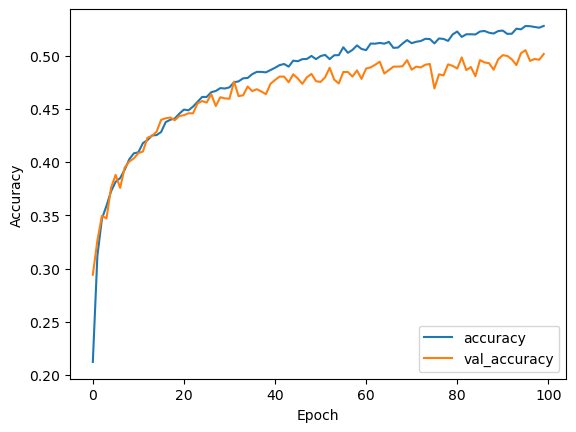

In [77]:
# plott accuracy
plt.plot(combined_history['accuracy'], label='accuracy')
plt.plot(combined_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

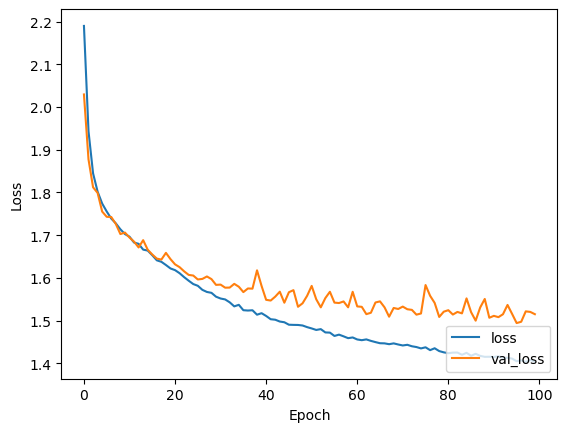

In [78]:
# plot error
plt.plot(combined_history['loss'], label = 'loss')
plt.plot(combined_history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [79]:
print("validation data",simple_model.evaluate(training_data))
print("validation data",simple_model.evaluate(validation_data))

351/351 [==============================] - 2s 5ms/step - loss: 1.4045 - accuracy: 0.5280
validation data [1.404481053352356, 0.5279957056045532]
87/87 [==============================] - 1s 5ms/step - loss: 1.5086 - accuracy: 0.5040
validation data [1.508561372756958, 0.5039511322975159]


## Helper Functions

In [109]:
# save model to disk
simple_model.save("simple_model")

INFO:tensorflow:Assets written to: simple_model\assets


INFO:tensorflow:Assets written to: simple_model\assets


In [133]:
# load model from disk
simple_model = tf.keras.models.load_model('simple_model')

## Confusion Matrix


In [134]:
predicted_labels = np.array([])
true_labels = np.array([])

for x, y in training_data:
    predicted_labels = np.concatenate([predicted_labels,
                       np.argmax(simple_model(x), axis=-1)])
    true_labels = np.concatenate([true_labels, y])



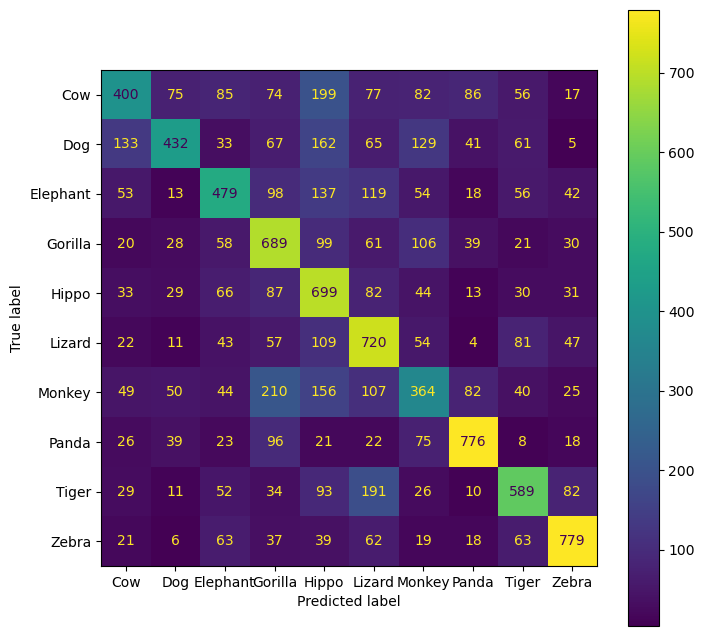

In [135]:
cm = confusion_matrix(true_labels, predicted_labels) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

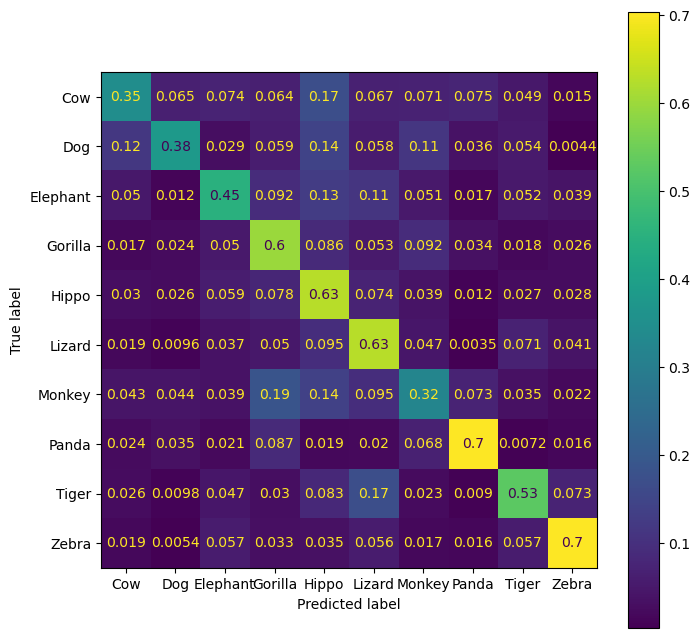

In [136]:
cm = confusion_matrix(true_labels, predicted_labels, normalize='true') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

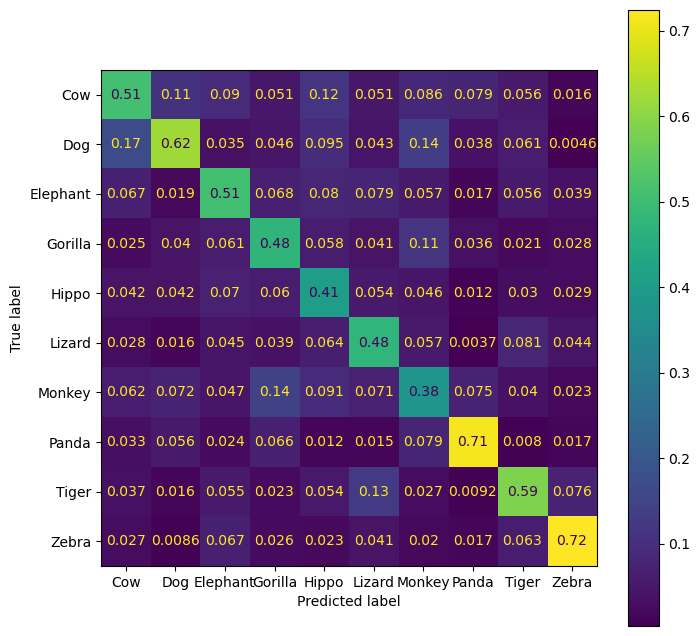

In [137]:
cm = confusion_matrix(true_labels, predicted_labels, normalize='pred') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

## Performance Discussion
From the graphical representations, it is evident that after undergoing training over 100 epochs, the model’s performance reaches a plateau, achieving approximately 0.52 accuracy in training and 0.50 in validation. This suggests that the simplicity of the model is a limiting factor in generating more accurate predictions. Moreover, after around 20 epochs, additional training appears to have a progressively diminished effect on both the accuracy and the loss metrics.

The confusion matrix, which provides insights into the model’s prediction capabilities across different categories, shows a relatively balanced distribution. However, it is clear that the model faces the greatest challenges when it comes to accurately identifying cows.

# Second Architecture (Overfitting)
For the second architecture, we designed a model similar to AlexNet, featuring five convolutional layers and two dense layers, totaling 6,649,642 trainable parameters.

In [19]:
#Notes:
## We used more or less a alexnet like aproach. ##
#https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7
#https://medium.com/@charlottecullip/a-comparison-of-cnn-architectures-part-2-8d03c67d8ec6
#https://www.geeksforgeeks.org/convolutional-neural-network-cnn-architectures/
#https://medium.com/@sajals1146/alexnet-architecture-993b760dec86

complex_model = models.Sequential()
# first
complex_model.add(layers.Conv2D(96, (6, 6),strides=2, activation='relu', input_shape=(img_height, img_width, img_channels)))
complex_model.add(layers.BatchNormalization())
# second
complex_model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
complex_model.add(layers.BatchNormalization())
# third
complex_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
complex_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
complex_model.add(layers.BatchNormalization())
#fourth
complex_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
complex_model.add(layers.BatchNormalization())
#fifth
complex_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
complex_model.add(layers.BatchNormalization())
complex_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
#deep
complex_model.add(layers.Flatten())
complex_model.add(layers.Dense(512, activation='relu'))
complex_model.add(layers.BatchNormalization())
complex_model.add(layers.Dense(256, activation='relu'))
complex_model.add(layers.BatchNormalization())
complex_model.add(layers.Dense(10))
complex_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        10464     
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       307328    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                        

In [20]:
complex_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
# history dictionary for successive combined trainings
combined_complex_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [27]:
# save history data to disk for later use
# Save the dictionary to disk using JSON
with open('combined_history_complex_model.json', 'w') as f:
    json.dump(combined_complex_history, f)

In [45]:
# load history data from disk
with open('combined_history_complex_model.json', 'r') as f:
    combined_complex_history = json.load(f)

In [22]:
# train
history = complex_model.fit(training_data, epochs=100, 
                           validation_data=validation_data)
# Update the combined_history with the first training session
for key in combined_complex_history.keys():
    combined_complex_history[key].extend(history.history[key])

Epoch 1/100


351/351 [==============================] - 12s 23ms/step - loss: 1.8127 - accuracy: 0.3843 - val_loss: 4.3274 - val_accuracy: 0.1455
Epoch 2/100
351/351 [==============================] - 8s 22ms/step - loss: 1.3663 - accuracy: 0.5402 - val_loss: 2.6429 - val_accuracy: 0.2525
Epoch 3/100
351/351 [==============================] - 8s 22ms/step - loss: 1.1626 - accuracy: 0.6109 - val_loss: 2.9586 - val_accuracy: 0.1911
Epoch 4/100
351/351 [==============================] - 8s 22ms/step - loss: 1.0748 - accuracy: 0.6402 - val_loss: 1.9844 - val_accuracy: 0.3983
Epoch 5/100
351/351 [==============================] - 8s 22ms/step - loss: 0.9540 - accuracy: 0.6844 - val_loss: 1.8639 - val_accuracy: 0.4371
Epoch 6/100
351/351 [==============================] - 8s 22ms/step - loss: 0.8284 - accuracy: 0.7202 - val_loss: 1.3044 - val_accuracy: 0.5923
Epoch 7/100
351/351 [==============================] - 8s 22ms/step - loss: 0.7214 - accuracy: 0.7568 - val_loss: 1.1952 - val_accuracy: 0.6200
Epo

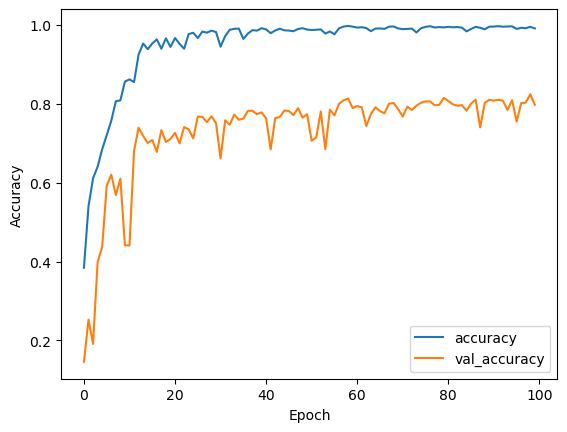

In [23]:
# plot accuracy
plt.plot(combined_complex_history['accuracy'], label='accuracy')
plt.plot(combined_complex_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

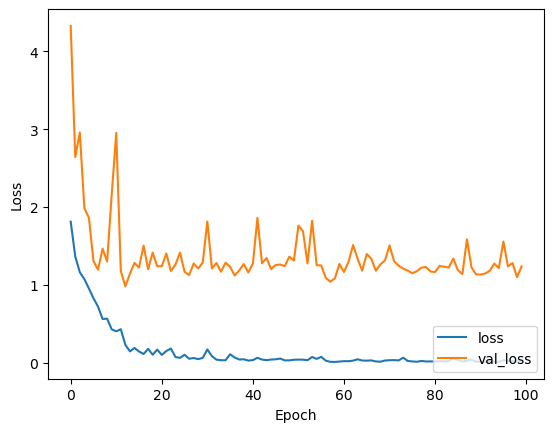

In [24]:
# plot error
plt.plot(combined_complex_history['loss'], label = 'loss')
plt.plot(combined_complex_history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [25]:
print("validation data",complex_model.evaluate(training_data))
print("validation data",complex_model.evaluate(validation_data))

351/351 [==============================] - 4s 9ms/step - loss: 0.0168 - accuracy: 0.9951
validation data [0.016750875860452652, 0.9950962662696838]
87/87 [==============================] - 1s 9ms/step - loss: 1.2323 - accuracy: 0.7981
validation data [1.2323384284973145, 0.7981321811676025]


## Helper Functions

In [26]:
# save model to disk
complex_model.save("complex_model")

INFO:tensorflow:Assets written to: complex_model\assets


INFO:tensorflow:Assets written to: complex_model\assets


In [49]:
complex_model = tf.keras.models.load_model('complex_model')

## Confusion Matrix

In [28]:
predicted_labels = np.array([])
true_labels = np.array([])

for x, y in training_data:
    predicted_labels = np.concatenate([predicted_labels,
                       np.argmax(complex_model(x), axis=-1)])
    true_labels = np.concatenate([true_labels, y])



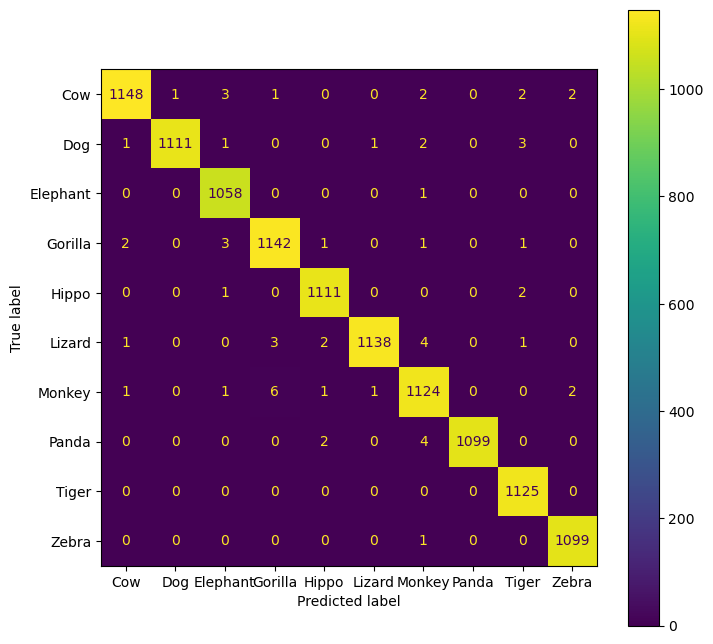

In [29]:
cm = confusion_matrix(true_labels,predicted_labels) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

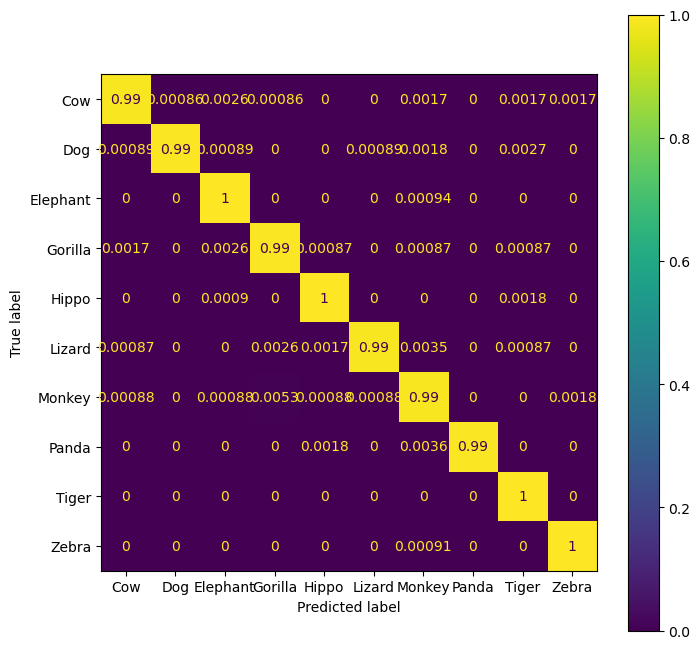

In [30]:
cm = confusion_matrix(true_labels, predicted_labels, normalize='true') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

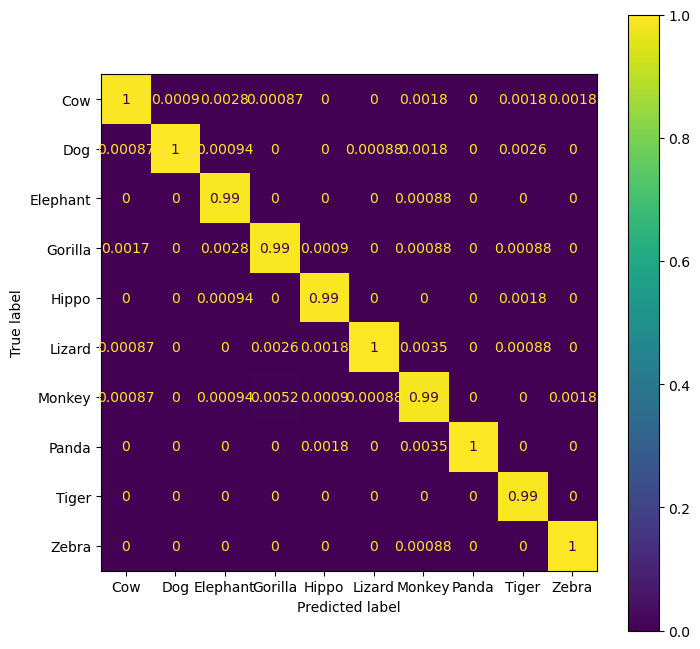

In [31]:
cm = confusion_matrix(true_labels, predicted_labels, normalize='pred') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

## Confusion Matrix - Validation

In [34]:
predicted_labels = np.array([])
true_labels = np.array([])

for x, y in validation_data:
    predicted_labels = np.concatenate([predicted_labels,
                       np.argmax(complex_model(x), axis=-1)])
    true_labels = np.concatenate([true_labels, y])



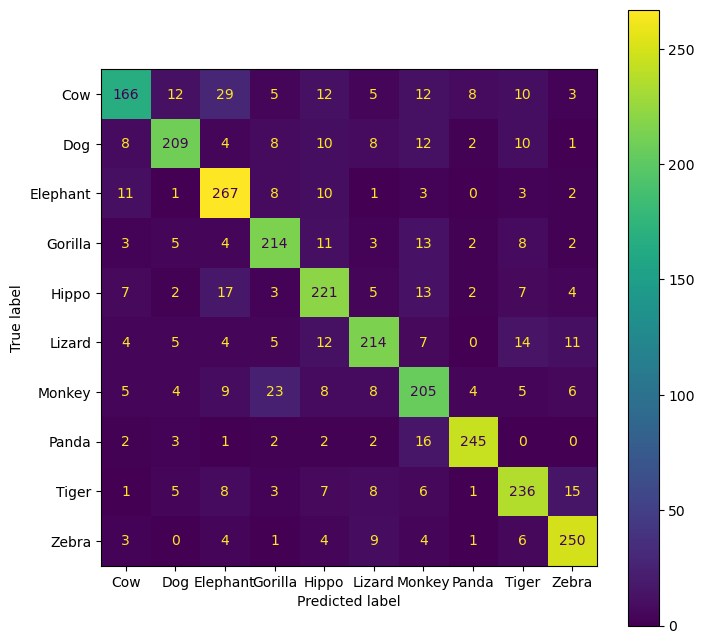

In [35]:
cm = confusion_matrix(true_labels,predicted_labels) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

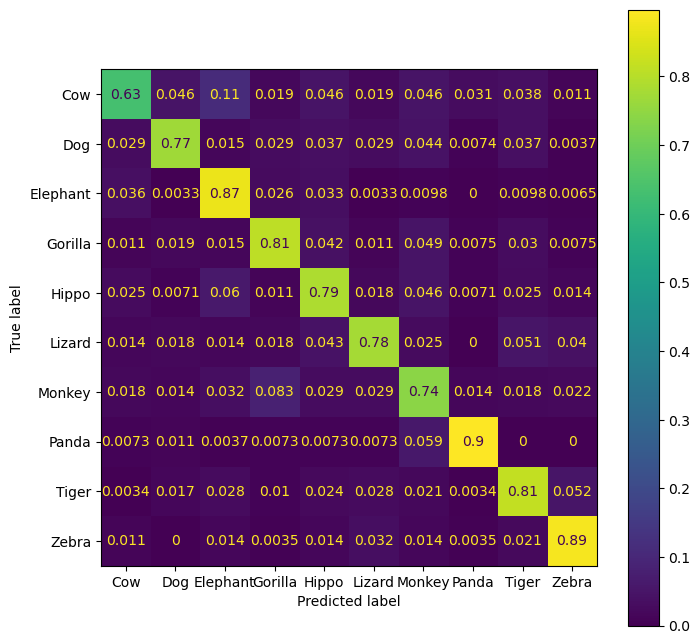

In [36]:
cm = confusion_matrix(true_labels, predicted_labels, normalize='true') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

## Performance Discussion
The model, featuring 6,649,642 trainable parameters but lacking any form of regularization, achieves good training accuracy of 0.99. However, the validation accuracy is only 0.7981, which points to overfitting, as indicated by the significant disparity between training and validation results. This large gap suggests that while the model effectively learns specific details from the training dataset, it has difficulties generalizing this knowledge to new, unseen data.

The confusion matrix for the validation data reveals an even distribution of prediction accuracy across different classes. Nevertheless, the model consistently struggles with the accurate identification of cows. This ongoing issue could be due to either the quality or the representativeness of the data for this particular category or could indicate a limitation in the model’s ability to extract and learn features specific to cows.

Observations indicate that after approximately 20 epochs, the model ceases to show substantial improvement in both accuracy and loss metrics, signifying a plateau. This lack of progress beyond the early stages of training suggests that the model may have reached the extent of its learning capacity given the current setup. This situation underscores the potential necessity for introducing regularization strategies or considering different architectural choices to enhance the model’s ability to generalize and improve performance on unseen data.

Despite these indications, there isn't an explicit sign of worsening overfitting in terms of increasing validation loss or decreasing validation accuracy. This absence of deterioration could suggest that while the model is not ideally generalized, it maintains a level of stability in its predictions on validation data.

# Third Architecture ("Optimized")

In [113]:
drop_parms = [0.1,0.3, 0.5]
l2_parms = [0.000001, 0.001, 1, 1000]
# dropout 0.1 and 0.5
# 10-6 to 10-3 (here also 1 and 1000 to show change)

all_histories = {}
# iterate and train on the different regularization parameters
for drop_rate in drop_parms:
    for l2_value in l2_parms:
        
        complex_opt_model = models.Sequential()
        # first
        complex_opt_model.add(layers.Conv2D(96, (6, 6),strides=2, activation='relu' , kernel_regularizer=tf.keras.regularizers.l2(l2_value), input_shape=(img_height, img_width, img_channels)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))

        # second
        complex_opt_model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        # third
        complex_opt_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
        complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        #fourth
        complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        #fifth
        complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
        complex_opt_model.add(layers.Dropout(drop_rate))
        #deep
        complex_opt_model.add(layers.Flatten())
        complex_opt_model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        complex_opt_model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_value)))
        complex_opt_model.add(layers.BatchNormalization())
        complex_opt_model.add(layers.Dropout(drop_rate))
        complex_opt_model.add(layers.Dense(10))
        complex_opt_model.summary()

        complex_opt_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        
        history = complex_opt_model.fit(training_data, epochs=25, 
                                validation_data=validation_data)

        # Store training history
        all_histories[str(drop_rate)+"_"+str(l2_value)] = history.history
        
        # Save the dictionary to disk using JSON
        with open('optimized_model_all_history.json', 'w') as f:
            json.dump(all_histories, f)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 30, 30, 96)        10464     
                                                                 
 batch_normalization_168 (Ba  (None, 30, 30, 96)       384       
 tchNormalization)                                               
                                                                 
 dropout_161 (Dropout)       (None, 30, 30, 96)        0         
                                                                 
 conv2d_121 (Conv2D)         (None, 30, 30, 128)       307328    
                                                                 
 batch_normalization_169 (Ba  (None, 30, 30, 128)      512       
 tchNormalization)                                               
                                                                 
 dropout_162 (Dropout)       (None, 30, 30, 128)     

In [111]:
# load history data from disk
with open('optimized_model_all_history.json', 'r') as f:
    all_histories = json.load(f)

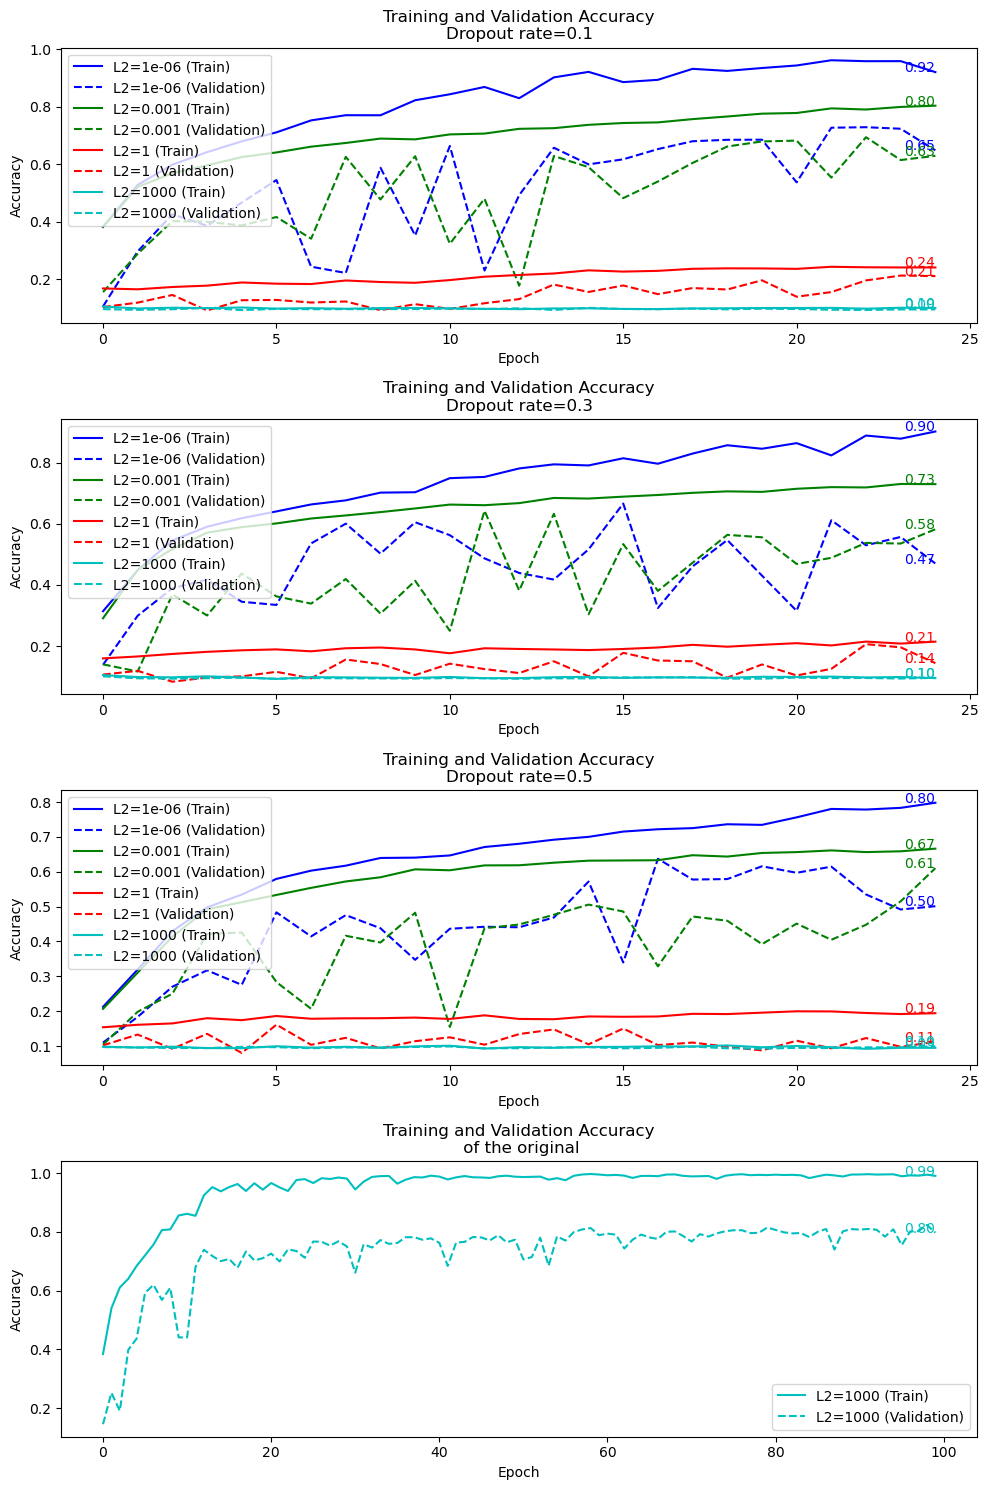

In [114]:
# plot the history data of the different regularization parameters
colors = ['b', 'g', 'r', 'c']  # Different color for each L2 value

fig, axes = plt.subplots(nrows=len(drop_parms)+1, ncols=1, figsize=(10, 15))

for i, drop_rate in enumerate(drop_parms):
    ax = axes[i]  # Select the appropriate subplot
    for j, l2_value in enumerate(l2_parms):
        key = f"{drop_rate}_{l2_value}"
        if key in all_histories:
            history = all_histories[key]
            if 'accuracy' in history and 'val_accuracy' in history:
                # Plot training and validation accuracy
                ax.plot(history['accuracy'], label=f'L2={l2_value} (Train)', color=colors[j])
                ax.plot(history['val_accuracy'], label=f'L2={l2_value} (Validation)', color=colors[j], linestyle='--')
                
                # Annotate the last value of each line
                last_epoch = len(history['accuracy']) - 1
                last_acc = history['accuracy'][-1]
                last_val_acc = history['val_accuracy'][-1]
                ax.text(last_epoch, last_acc, f'{last_acc:.2f}', color=colors[j], horizontalalignment='right')
                ax.text(last_epoch, last_val_acc, f'{last_val_acc:.2f}', color=colors[j], horizontalalignment='right')

    ax.set_title(f'Training and Validation Accuracy\nDropout rate={drop_rate}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()

ax = axes[len(drop_parms)]
# Plot training and validation accuracy
ax.plot(combined_complex_history['accuracy'], label=f'L2={l2_value} (Train)', color=colors[j])
ax.plot(combined_complex_history['val_accuracy'], label=f'L2={l2_value} (Validation)', color=colors[j], linestyle='--')
# Annotate the last value of each line
last_epoch = len(combined_complex_history['accuracy']) - 1
last_acc = combined_complex_history['accuracy'][-1]
last_val_acc = combined_complex_history['val_accuracy'][-1]
ax.text(last_epoch, last_acc, f'{last_acc:.2f}', color=colors[j], horizontalalignment='right')
ax.text(last_epoch, last_val_acc, f'{last_val_acc:.2f}', color=colors[j], horizontalalignment='right')
ax.set_title(f'Training and Validation Accuracy\n of the original')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()


plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
plt.show()

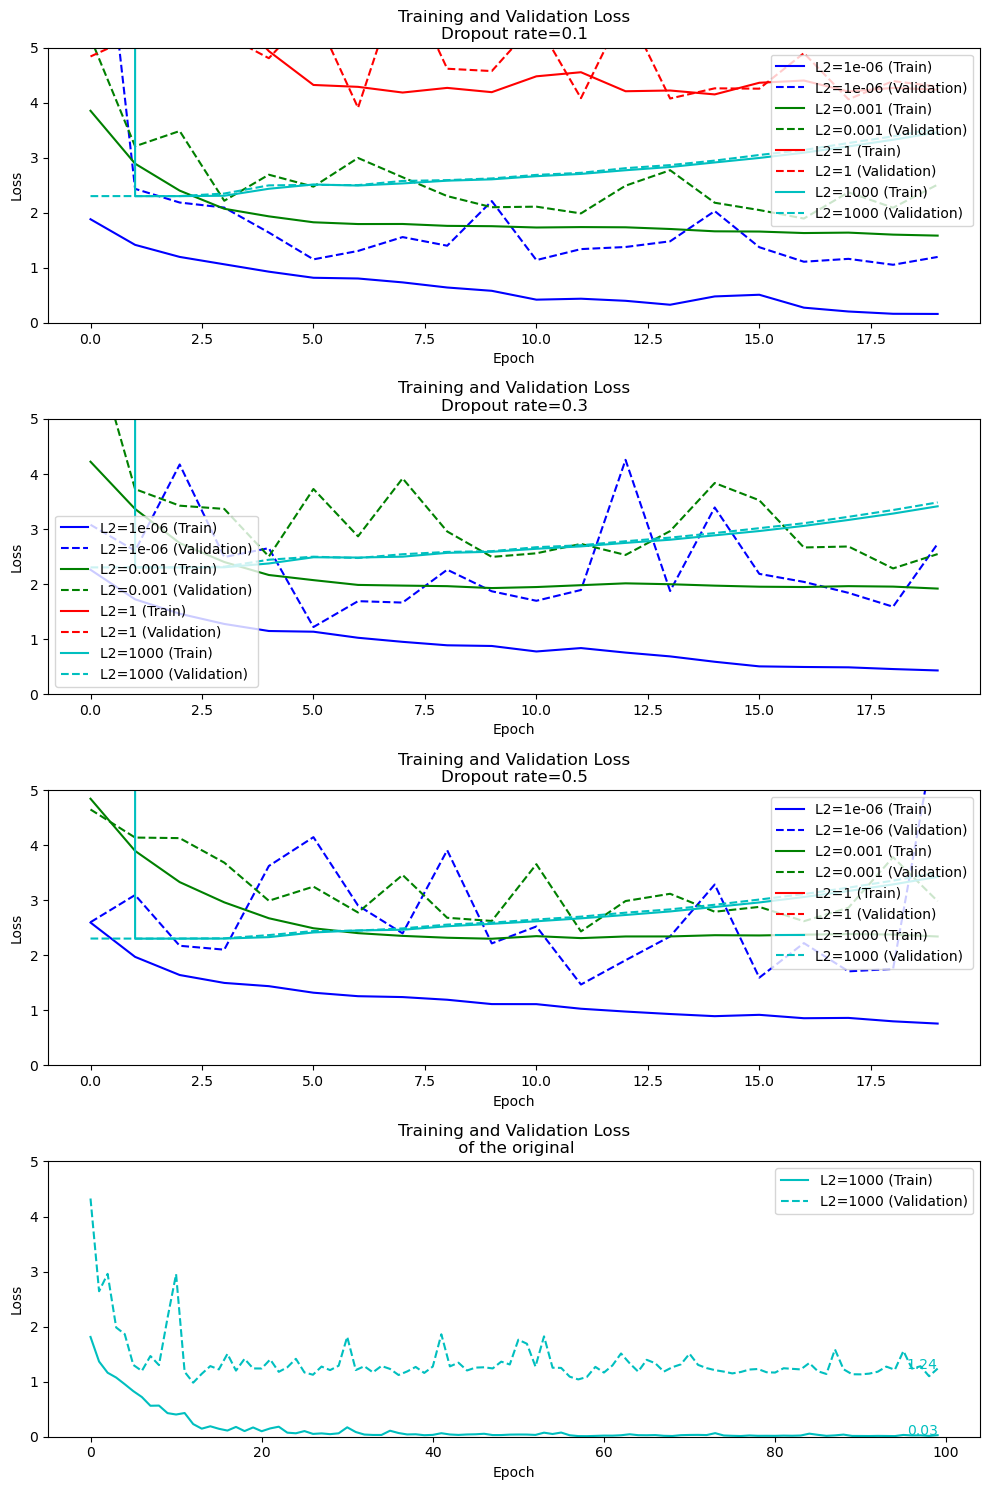

In [57]:

colors = ['b', 'g', 'r', 'c']  # Different color for each L2 value

fig, axes = plt.subplots(nrows=len(drop_parms)+1, ncols=1, figsize=(10, 15))

for i, drop_rate in enumerate(drop_parms):
    ax = axes[i]  # Select the appropriate subplot
    for j, l2_value in enumerate(l2_parms):
        key = f"{drop_rate}_{l2_value}"
        if key in all_histories:
            history = all_histories[key]
            if 'loss' in history and 'val_loss' in history:
                # Plot training and validation loss
                ax.plot(history['loss'], label=f'L2={l2_value} (Train)', color=colors[j])
                ax.plot(history['val_loss'], label=f'L2={l2_value} (Validation)', color=colors[j], linestyle='--')

    ax.set_title(f'Training and Validation Loss\nDropout rate={drop_rate}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_ylim([0, 5])  # Limit y-axis
    ax.legend()

ax = axes[len(drop_parms)]
# Plot training and validation loss for the original model
ax.plot(combined_complex_history['loss'], label=f'L2={l2_value} (Train)', color=colors[j])
ax.plot(combined_complex_history['val_loss'], label=f'L2={l2_value} (Validation)', color=colors[j], linestyle='--')
# Annotate the last value of each line
last_epoch = len(combined_complex_history['loss']) - 1
last_acc = combined_complex_history['loss'][-1]
last_val_acc = combined_complex_history['val_loss'][-1]
ax.text(last_epoch, last_acc, f'{last_acc:.2f}', color=colors[j], horizontalalignment='right')
ax.text(last_epoch, last_val_acc, f'{last_val_acc:.2f}', color=colors[j], horizontalalignment='right')
ax.set_title(f'Training and Validation Loss\n of the original')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_ylim([0, 5])  # Limit y-axis
ax.legend()

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
plt.show()

## Choice of Parameter 
We tested three different dropout values and four L2 lambda values, due to the long time it takes to train this model on a CPU, escalating the lambda incrementally by 1000 at each step. Higher dropout values tended to degrade model performance slightly, indicating a potential over-penalization or excessive loss of useful features during training. Interestingly, implementing dropout alone did not significantly narrow the gap between training and validation accuracy, suggesting that while dropout helped in preventing some overfitting, it was insufficient by itself to align the two accuracies closely.

Regarding the L2 regularization, increasing the lambda values also did not result in noticeable improvements in mitigating overfitting. Instead, the larger lambda values substantially degraded both training and validation performance. This deterioration is likely due to the L2 regularization excessively penalizing the model's weight parameters, leading to underfitting where the model becomes too simple to capture the underlying patterns in the data effectively.

Given these outcomes, there was a convergence observed: as both the training and validation accuracies decreased, their values started aligning more closely. This suggests that while the regularization techniques made the model less capable of fitting the training data perfectly (thus lowering training accuracy), they similarly reduced the gap between the training and validation results by curtailing the model's tendency to overfit.

Considering these observations and aiming to proceed with a functional model, we opted for lower regularization values. We settled on a dropout rate of 0.1 and an L2 lambda of 0.000001. These values were chosen to maintain a balance between preventing overfitting and avoiding too much compromise on the model’s ability to learn from the training data.


In [79]:
final_drop_rate = 0.1
final_l2_value = 0.000001
        
complex_opt_model = models.Sequential()
# first
complex_opt_model.add(layers.Conv2D(96, (6, 6),strides=2, activation='relu' , kernel_regularizer=tf.keras.regularizers.l2(final_l2_value), input_shape=(img_height, img_width, img_channels)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(final_drop_rate))

# second
complex_opt_model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(final_drop_rate))
# third
complex_opt_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(final_drop_rate))
#fourth
complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(final_drop_rate))
#fifth
complex_opt_model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
complex_opt_model.add(layers.Dropout(final_drop_rate))
#deep
complex_opt_model.add(layers.Flatten())
complex_opt_model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(final_drop_rate))
complex_opt_model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model.add(layers.BatchNormalization())
complex_opt_model.add(layers.Dropout(final_drop_rate))
complex_opt_model.add(layers.Dense(10))
complex_opt_model.summary()

complex_opt_model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 30, 30, 96)        10464     
                                                                 
 batch_normalization_140 (Ba  (None, 30, 30, 96)       384       
 tchNormalization)                                               
                                                                 
 dropout_133 (Dropout)       (None, 30, 30, 96)        0         
                                                                 
 conv2d_101 (Conv2D)         (None, 30, 30, 128)       307328    
                                                                 
 batch_normalization_141 (Ba  (None, 30, 30, 128)      512       
 tchNormalization)                                               
                                                                 
 dropout_134 (Dropout)       (None, 30, 30, 128)     

In [80]:
# history dictionary for successive combined trainings
combined_complex_opt_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [87]:
# save history data to disk
# Save the dictionary to disk using JSON
with open('optimized_model.json', 'w') as f:
    json.dump(combined_complex_opt_history, f)

In [ ]:
# load history data from disk
with open('optimized_model.json', 'r') as f:
    combined_complex_opt_history = json.load(f)

In [81]:
# train the model
history = complex_opt_model.fit(training_data, epochs=100, 
                           validation_data=validation_data)
# Update the combined_history with the first training session
for key in combined_complex_opt_history.keys():
    combined_complex_opt_history[key].extend(history.history[key])

Epoch 1/100


351/351 [==============================] - 12s 27ms/step - loss: 1.7960 - accuracy: 0.4034 - val_loss: 7.4936 - val_accuracy: 0.1017
Epoch 2/100
351/351 [==============================] - 10s 26ms/step - loss: 1.3710 - accuracy: 0.5459 - val_loss: 2.2573 - val_accuracy: 0.2859
Epoch 3/100
351/351 [==============================] - 10s 25ms/step - loss: 1.1851 - accuracy: 0.6036 - val_loss: 1.7174 - val_accuracy: 0.4626
Epoch 4/100
351/351 [==============================] - 10s 25ms/step - loss: 1.0496 - accuracy: 0.6484 - val_loss: 3.0413 - val_accuracy: 0.2863
Epoch 5/100
351/351 [==============================] - 10s 25ms/step - loss: 0.9224 - accuracy: 0.6939 - val_loss: 1.8884 - val_accuracy: 0.4688
Epoch 6/100
351/351 [==============================] - 10s 25ms/step - loss: 0.8490 - accuracy: 0.7180 - val_loss: 1.2717 - val_accuracy: 0.6088
Epoch 7/100
351/351 [==============================] - 10s 26ms/step - loss: 0.7807 - accuracy: 0.7400 - val_loss: 1.4279 - val_accuracy: 0.55

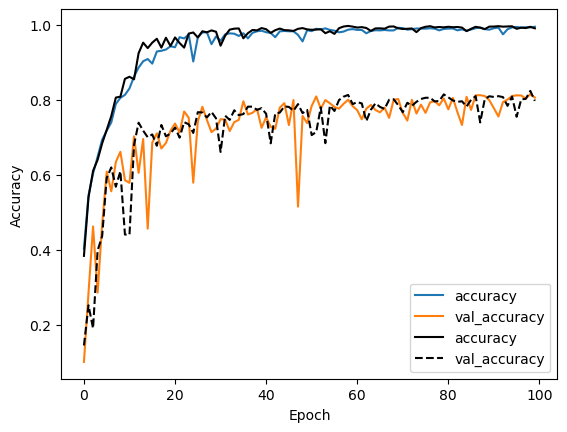

In [83]:
# plot accuracy
plt.plot(combined_complex_opt_history['accuracy'], label='accuracy')
plt.plot(combined_complex_opt_history['val_accuracy'], label = 'val_accuracy')
plt.plot(combined_complex_history['accuracy'], label='accuracy', color='black')
plt.plot(combined_complex_history['val_accuracy'], label = 'val_accuracy', color='black', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

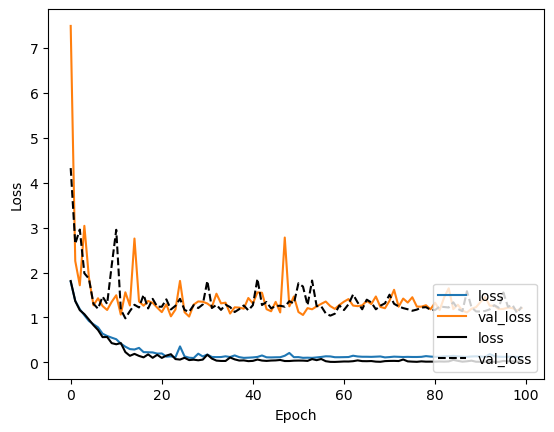

In [84]:
# plot error
plt.plot(combined_complex_opt_history['loss'], label = 'loss')
plt.plot(combined_complex_opt_history['val_loss'], label='val_loss')
plt.plot(combined_complex_history['loss'], label = 'loss', color='black')
plt.plot(combined_complex_history['val_loss'], label='val_loss', color='black', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [85]:
print("2, validation data",complex_opt_model.evaluate(training_data))
print("2, validation data",complex_opt_model.evaluate(validation_data))

351/351 [==============================] - 4s 10ms/step - loss: 0.1143 - accuracy: 0.9975
2, validation data [0.11434196680784225, 0.9975035786628723]
87/87 [==============================] - 1s 10ms/step - loss: 1.2122 - accuracy: 0.8064
2, validation data [1.212177038192749, 0.8063936829566956]


In [88]:
# save model to disk
complex_opt_model.save("optimized_model")

INFO:tensorflow:Assets written to: optimized_model\assets


INFO:tensorflow:Assets written to: optimized_model\assets


In [ ]:
# load model from disk
complex_opt_model = tf.keras.models.load_model('optimized_model')

## Confusion Matrix

In [100]:
predicted_labels_co = np.array([])
true_labels_co = np.array([])

for x, y in validation_data:
    predicted_labels_co = np.concatenate([predicted_labels_co,
                       np.argmax(complex_opt_model(x), axis=-1)])
    true_labels_co = np.concatenate([true_labels_co, y])

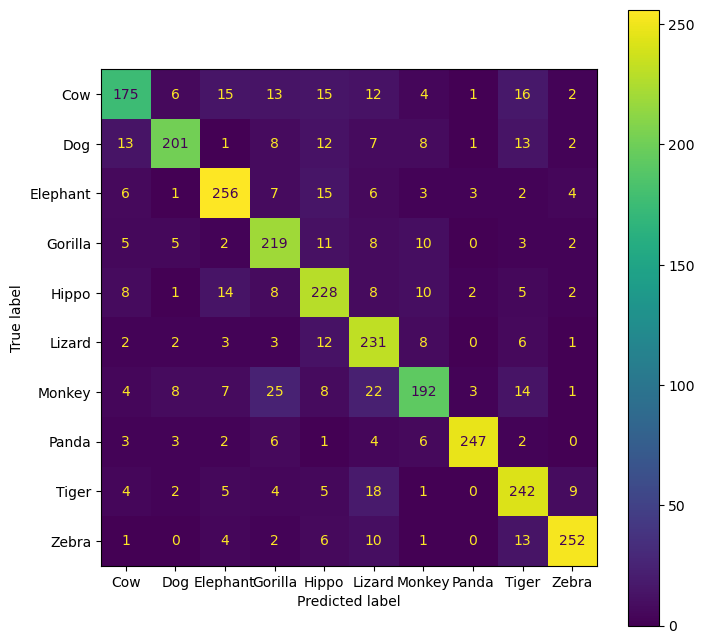

In [101]:
cm = confusion_matrix(true_labels_co,predicted_labels_co) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

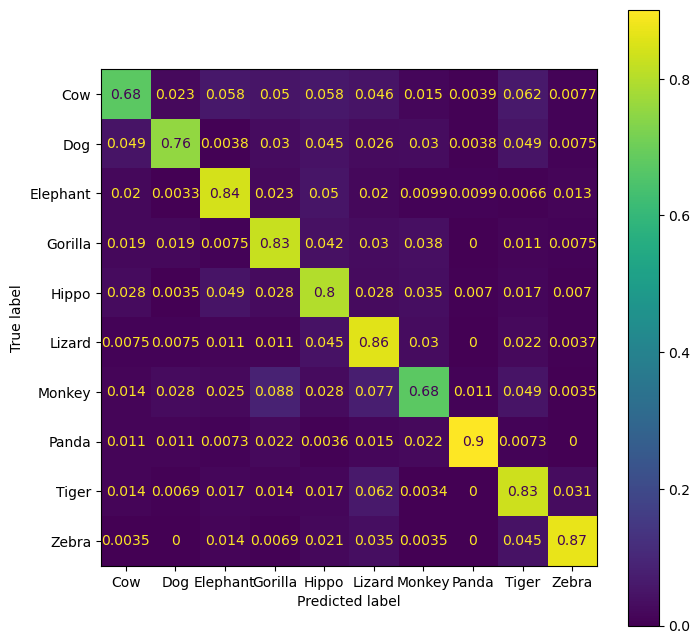

In [102]:
cm = confusion_matrix(true_labels_co, predicted_labels_co, normalize='true') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

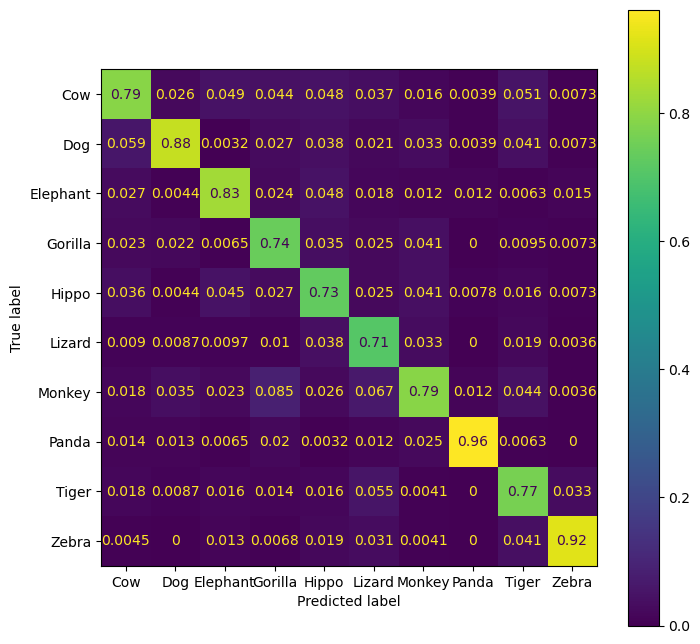

In [103]:
cm = confusion_matrix(true_labels_co, predicted_labels_co, normalize='pred') 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

## Performance Discussion
In the latest round of model adjustments, we implemented both dropout and L2 regularization with set parameters of 0.1 and 0.000001, respectively. The outcomes of these adjustments show only a marginal difference in model performance compared to the previous configuration.

The new model's training accuracy reached 0.9857 with a corresponding loss of 0.1865. For validation, the accuracy was 0.7999 with a loss of 1.3710. When compared to the previous model—which recorded a training accuracy of 0.9951 and a loss of 0.0168, alongside a validation accuracy of 0.7981 and a loss of 1.2323—the new results highlight several key points:

There is a slight decrease in training accuracy from 0.9951 to 0.9857, and a noticeable increase in training loss from 0.0168 to 0.1865. This change can be attributed to the introduction of dropout and a very small amount of L2 regularization, which are intended to reduce overfitting by slightly impairing the model’s ability to fit perfectly to the training data. The increased training loss suggests that the model is no longer tailoring its learning as closely to the training data specifics, which is a typical outcome when applying regularization.

The validation accuracy remains almost unchanged, moving from 0.7981 to 0.7999. However, there is an increase in validation loss from 1.2323 to 1.3710. This slight increase in loss, despite stable accuracy, could indicate that while the model's predictions remain correct at about the same rate, the confidence of those predictions has worsened.

These observations suggest that while the dropout and minimal L2 regularization have helped in preventing the model from overfitting (as seen from the reduced gap between training and validation accuracies), they also introduce a challenge where the model becomes slightly less confident in its predictions, as evidenced by the increased validation loss.

The confusion matrix shows that there is virtually no change in how well the model classifies different classes compared to the previous model configurations. 


# Quantification of the model performance

## Classification Metrics

### Accuracy, Precision, Recall, F1


In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predicted_labels_sc_co = np.array([])
true_labels_sc_co = np.array([])

validation_predicted_labels_sc_co = np.array([])
validation_true_labels_sc_co = np.array([])

for x, y in training_data:
    predicted_labels_sc_co = np.concatenate([predicted_labels_sc_co,
                       np.argmax(complex_opt_model(x), axis=-1)])
    true_labels_sc_co = np.concatenate([true_labels_sc_co, y])

for x, y in validation_data:
    validation_predicted_labels_sc_co = np.concatenate([validation_predicted_labels_sc_co,
                       np.argmax(complex_opt_model(x), axis=-1)])
    validation_true_labels_sc_co = np.concatenate([validation_true_labels_sc_co, y])


In [94]:
print(accuracy_score(true_labels_sc_co,predicted_labels_sc_co))
print(accuracy_score(validation_true_labels_sc_co,validation_predicted_labels_sc_co))

0.9975035663338089
0.8063936781609196


In [98]:
print(precision_score(true_labels_sc_co,predicted_labels_sc_co, average=None))
print(precision_score(validation_true_labels_sc_co,validation_predicted_labels_sc_co, average=None))

print(precision_score(true_labels_sc_co,predicted_labels_sc_co, average='macro'))
print(precision_score(validation_true_labels_sc_co,validation_predicted_labels_sc_co, average='macro'))

[1.         1.         0.99811853 0.99565595 0.99197861 0.99654875
 0.99910714 1.         0.99375558 1.        ]
[0.80349345 0.87826087 0.82679739 0.73972603 0.72815534 0.70987654
 0.7944664  0.96015936 0.76507937 0.91636364]
0.9975164560585391
0.8122378382535611


In [99]:
print(recall_score(true_labels_sc_co,predicted_labels_sc_co, average=None))
print(recall_score(validation_true_labels_sc_co,validation_predicted_labels_sc_co, average=None))

print(recall_score(true_labels_sc_co,predicted_labels_sc_co, average='macro'))
print(recall_score(validation_true_labels_sc_co,validation_predicted_labels_sc_co, average='macro'))

[0.99306158 0.9964539  0.99905838 1.         0.99641898 1.
 0.99466667 0.99909747 0.99910314 0.99728997]
[0.68656716 0.75655431 0.84053156 0.82442748 0.795053   0.86142322
 0.68600683 0.90262172 0.83680556 0.875     ]
0.9975150090527594
0.8064990842520949


The recall scores for the training set are high across all classes, ranging from 0.99306158 to 1.00, with a macro average of 0.9975150090527594. These scores indicate that the model is almost perfectly capable of identifying relevant instances across all categories in the training set.
On the validation set, recall scores are lower and more variable, ranging from 0.68600683 to 0.90262172 with a macro average of 0.8064990842520949. This variability and drop in recall suggest that while the model can still identify a majority of relevant instances in unseen data, its performance is inconsistent across different classes.

In [104]:
print(f1_score(true_labels_sc_co,predicted_labels_sc_co, average=None))
print(f1_score(validation_true_labels_sc_co,validation_predicted_labels_sc_co,  average=None))

print(f1_score(true_labels_sc_co,predicted_labels_sc_co, average='macro'))
print(f1_score(validation_true_labels_sc_co,validation_predicted_labels_sc_co,  average='macro'))

[0.99651871 0.9982238  0.99858824 0.99782325 0.99419384 0.99827139
 0.99688196 0.99954853 0.99642218 0.99864315]
[0.74044266 0.81287726 0.83360791 0.77978339 0.76013514 0.77834179
 0.73626374 0.93050193 0.79933665 0.89520426]
0.9975115047069508
0.806649472919329


The training F1 scores, which combine precision and recall, are very high, demonstrating the model's robustness in balancing the detection of relevant instances while minimizing false positives. The scores range from 0.99419384 to 0.99954853, with a macro average of 0.9975115047069508.
The validation F1 scores show a significant decrease compared to training scores, ranging from 0.73626374 to 0.93050193, with a macro average of 0.806649472919329. The scores highlight the challenges the model faces in maintaining a balanced performance in precision and recall when applied to new data.

## Generalization, K-Fold

In [105]:
from sklearn.model_selection import KFold

x = []
y = []

for image, label in training_data.concatenate(validation_data).unbatch():
    x.append(image.numpy())
    y.append(label.numpy())

x = np.array(x)
y = np.array(y)

In [108]:
# Define the number of splits for cross-validation
nr_of_splits = 4
kf = KFold(n_splits=nr_of_splits, shuffle=True)

val_errors_list = []
val_acc_list = []

final_drop_rate = 0.1
final_l2_value = 0.000001
        
complex_opt_model_kfold = models.Sequential()
# first
complex_opt_model_kfold.add(layers.Conv2D(96, (6, 6),strides=2, activation='relu' , kernel_regularizer=tf.keras.regularizers.l2(final_l2_value), input_shape=(img_height, img_width, img_channels)))
complex_opt_model_kfold.add(layers.BatchNormalization())
complex_opt_model_kfold.add(layers.Dropout(final_drop_rate))

# second
complex_opt_model_kfold.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model_kfold.add(layers.BatchNormalization())
complex_opt_model_kfold.add(layers.Dropout(final_drop_rate))
# third
complex_opt_model_kfold.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
complex_opt_model_kfold.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model_kfold.add(layers.BatchNormalization())
complex_opt_model_kfold.add(layers.Dropout(final_drop_rate))
#fourth
complex_opt_model_kfold.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model_kfold.add(layers.BatchNormalization())
complex_opt_model_kfold.add(layers.Dropout(final_drop_rate))
#fifth
complex_opt_model_kfold.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model_kfold.add(layers.BatchNormalization())
complex_opt_model_kfold.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
complex_opt_model_kfold.add(layers.Dropout(final_drop_rate))
#deep
complex_opt_model_kfold.add(layers.Flatten())
complex_opt_model_kfold.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model_kfold.add(layers.BatchNormalization())
complex_opt_model_kfold.add(layers.Dropout(final_drop_rate))
complex_opt_model_kfold.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(final_l2_value)))
complex_opt_model_kfold.add(layers.BatchNormalization())
complex_opt_model_kfold.add(layers.Dropout(final_drop_rate))
complex_opt_model_kfold.add(layers.Dense(10))
complex_opt_model_kfold.summary()

complex_opt_model_kfold.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

for train_index, val_index in kf.split(x):
    
    # Split data into training and validation sets
    X_train_fold, X_val_fold = x[train_index], x[val_index]
    Y_train_fold, Y_val_fold = y[train_index], y[val_index]
    
    # Train your TensorFlow model on the training data
    complex_opt_model_kfold.fit(X_train_fold, Y_train_fold, epochs=25, batch_size=32)
    
    # Evaluate the model on the validation data
    val_error, val_acc = complex_opt_model_kfold.evaluate(X_val_fold, Y_val_fold)
    
    # Append the validation error to the list
    val_errors_list.append(val_error)
    val_acc_list.append(val_acc)

# Calculate mean and standard deviation of validation errors
val_error_mean = np.mean(val_errors_list)
val_error_std = np.std(val_errors_list)

print(val_errors_list)
print(f'Out-of-sample Root Mean Squared Error using {nr_of_splits}-fold CV:')
print(f'mean: {val_error_mean}\nstandard-deviation: {val_error_std}')

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_115 (Conv2D)         (None, 30, 30, 96)        10464     
                                                                 
 batch_normalization_161 (Ba  (None, 30, 30, 96)       384       
 tchNormalization)                                               
                                                                 
 dropout_154 (Dropout)       (None, 30, 30, 96)        0         
                                                                 
 conv2d_116 (Conv2D)         (None, 30, 30, 128)       307328    
                                                                 
 batch_normalization_162 (Ba  (None, 30, 30, 128)      512       
 tchNormalization)                                               
                                                                 
 dropout_155 (Dropout)       (None, 30, 30, 128)     

In [109]:
# Print validation accuracy and error
print(val_errors_list)
print(val_acc_list)

val_acc_mean = np.mean(val_acc_list)
val_acc_std = np.std(val_acc_list)

print(f'Out-of-sample Root Mean Squared Error / Acc using {nr_of_splits}-fold CV:')
print(f'loss mean: {val_error_mean}\nstandard-deviation: {val_error_std}')
print(f'accuracy mean: {val_acc_mean}\nstandard-deviation: {val_acc_std}')

[1.3707159757614136, 0.6527539491653442, 0.3389439582824707, 0.2565784454345703]
[0.7020000219345093, 0.8431428670883179, 0.9251428842544556, 0.9617142677307129]
Out-of-sample Root Mean Squared Error / Acc using 4-fold CV:
loss mean: 0.6547480821609497
standard-deviation: 0.4390003717260841
accuracy mean: 0.8580000102519989
standard-deviation: 0.0997766803813819


The cross-validation mean loss (0.6547) is significantly lower than the single validation run loss (1.2122), suggesting that the cross-validation gives a more favorable and possibly more accurate measure of how the model might perform on truly new data.
The cross-validation mean accuracy (85.80%) is higher than the single validation run accuracy (80.64%). This difference again supports the conclusion that the model is likely more robust than initially indicated by the single validation set.

The standard deviations from the k-fold CV (Loss: 0.4390, Accuracy: 9.98%) indicate there is some variability in the model performance across different subsets of data. A nearly 10% deviation in accuracy suggests the model's performance might fluctuate depending on the specific characteristics of the data it is trained and tested on.

The k-fold CV results suggest that the model has a better generalization ability than what was observed using the single validation set, with less loss and higher accuracy on average. 

## Test-Set


In [110]:
complex_opt_model.evaluate(test_data)

188/188 [==============================] - 2s 12ms/step - loss: 1.6710 - accuracy: 0.7532


[1.6709542274475098, 0.753166675567627]

#  Conclusion and Discussion

In conclusion, the analysis of three different models reveals varying outcomes in terms of training effectiveness and generalization capabilities.

The simple model demonstrated a reasonable balance in the confusion matrix, achieving 0.52 training and 0.5 validation accuracy after 100 epochs. Despite this balance, the model struggled notably with detecting cows, hinting at potential limitations in data quality or model capacity to handle this specific classification.

The second model is equipped with a significantly larger number of trainable parameters (6,649,642) but no regularization, this model achieved excellent training accuracy but only about 0.79 on validation,  indicating overfitting. The confusion matrix was balanced but, like the first model, had difficulties with cow detection. Post-20 epochs, further training showed negligible improvements, suggesting that merely increasing complexity without addressing overfitting is not effective.

The third model introduced dropout and L2 regularization at very conservative levels (dropout rate of 0.1 and L2 lambda of 0.000001). The adjustments led to slight declines in training accuracy and a marginal increase in validation accuracy, with a higher validation loss. These minor changes in performance metrics suggest that the specific settings of dropout and L2 were insufficient to significantly impact model behavior, particularly in overcoming overfitting challenges.

Adding to these insights, we note that the third model achieved a good training precision score of 0.9975164560585391 and a validation precision score of 0.8122378382535611, indicating good performance in class-specific accuracy. The precision scores for individual classes in training were nearly perfect across the board, showing values such as 1.00 for several classes and no lower than 0.99197861. In contrast, validation precision varied more significantly, with scores ranging from 0.70987654 to 0.96015936, suggesting variability in how well the model predicted different classes under unseen conditions.

The k-fold CV results suggest that the model has a better generalization ability than what was observed using the single validation set, with less loss and higher accuracy on average. 

Across all models, a common issue was the models' inability to effectively generalize from training to validation datasets, particularly evident in the significant gaps between training and validation accuracies. The recurring difficulty in detecting cows across different models suggests a persistent challenge related to either the feature extraction capabilities of the models or issues in the dataset itself, such as insufficient or poor-quality data on cows.
